In [1]:
# --- 1) Importi + iestatījumi ---
import os, time, random, pickle
from pathlib import Path
import numpy as np
import psutil
import matplotlib.pyplot as plt
import cv2
import insightface

# Sistēmas resursi
PROC = psutil.Process(os.getpid())

# ==== Pielāgo šeit ====
BASE = Path(r"C:\Users\dplau\Desktop\bakalaura_darbs\InsightFace\Dataset")
CACHE_DIR = BASE / "_cache_insightface"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

MODEL = "buffalo_l"      # ArcFace + RetinaFace
RESIZE_MAX = 640
USE_CACHE  = True
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Modeļa inicializācija
model = insightface.app.FaceAnalysis(name=MODEL, providers=['CPUExecutionProvider'])
model.prepare(ctx_id=0, det_size=(640, 640))


C:\Users\dplau\anaconda3\envs\frenv\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dplau/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dplau/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dplau/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dplau/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dplau/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

In [2]:
# --- 2) Palīgfunkcijas ---
def list_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png"}
    return sorted([p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in exts])

def load_and_downscale(path: Path, max_side=RESIZE_MAX):
    img = cv2.imread(str(path))
    if img is None: return None
    h, w = img.shape[:2]
    if max(h, w) > max_side:
        scale = max_side / float(max(h, w))
        img = cv2.resize(img, (int(w*scale), int(h*scale)))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def encode_one(path: Path):
    """Atgriež 512D embedding ar ArcFace, vai None ja seja nav atrasta."""
    cf = CACHE_DIR / (path.stem + ".pkl")
    if USE_CACHE and cf.exists():
        try: return pickle.load(open(cf, "rb"))
        except Exception: pass

    rgb = load_and_downscale(path)
    if rgb is None: return None

    faces = model.get(rgb)
    if not faces: 
        vec = None
    else:
        vec = faces[0].normed_embedding.astype(np.float32)

    if USE_CACHE: pickle.dump(vec, open(cf, "wb"))
    return vec

def l2n(v):
    n = np.linalg.norm(v) + 1e-12
    return v / n

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-12)


In [3]:
# --- 3) Galerija no train/ ---
persons = sorted([p.name for p in BASE.iterdir() if p.is_dir() and p.name.startswith("person")])
t0 = time.perf_counter()
gal_names, gal_vecs = [], []

for pname in persons:
    vecs = []
    for ip in list_images(BASE / pname / "train"):
        v = encode_one(ip)
        if v is not None: vecs.append(l2n(v))
    if vecs:
        gal_names.append(pname)
        gal_vecs.append(l2n(np.mean(np.stack(vecs, 0), 0)))

gal_names = np.array(gal_names)
gal_vecs  = np.array(gal_vecs)
t1 = time.perf_counter()
print(f"Galerija sagatavota: {len(gal_names)} personas. Laiks: {t1-t0:.2f}s")


Galerija sagatavota: 10 personas. Laiks: 0.04s


In [4]:
# --- 4) Sliekšņa kalibrācija (val/) ---
genuine, impostor = [], []

for pname in persons:
    for ip in list_images(BASE / pname / "val"):
        q = encode_one(ip)
        if q is None: continue
        qn = l2n(q)
        sims = [cosine_similarity(qn, g) for g in gal_vecs]
        mask = (gal_names == pname)
        if mask.any():   genuine.append(np.max(np.array(sims)[mask]))
        if (~mask).any(): impostor.append(np.max(np.array(sims)[~mask]))

genuine = np.array(genuine)
impostor = np.array(impostor)

def eer_from_scores(genuine, impostor):
    if len(genuine)==0 or len(impostor)==0: return 0.5, np.nan
    cand = np.linspace(-1, 1, 400)
    best_tau, best_gap, best_eer = 0, 1, 1
    for t in cand:
        FAR = (impostor >= t).mean()
        FRR = (genuine  <  t).mean()
        gap = abs(FAR - FRR)
        if gap < best_gap:
            best_tau, best_gap, best_eer = t, gap, (FAR+FRR)/2
    return best_tau, best_eer

tau_eer, eer_val = eer_from_scores(genuine, impostor)
print(f"τ_EER (val) = {tau_eer:.4f} | EER(val) ≈ {100*eer_val:.2f}%")


τ_EER (val) = 0.1629 | EER(val) ≈ 3.23%


In [5]:
# --- 5) Tests ---
rows = []  # (person, file, pred, score, ms, fps, ram, cpu)

for pname in persons:
    for ip in list_images(BASE / pname / "test"):
        t0 = time.perf_counter()
        q = encode_one(ip)
        t1 = time.perf_counter()

        if q is None:
            pred, score = "No face", -1
        else:
            qn = l2n(q)
            sims = [cosine_similarity(qn, g) for g in gal_vecs]
            j = np.argmax(sims); score = sims[j]
            pred = gal_names[j] if score >= tau_eer else "Unknown"

        mem = PROC.memory_info().rss/(1024*1024)
        cpu = psutil.cpu_percent(interval=None)
        dt  = t1 - t0
        rows.append((pname, ip.name, pred, score, dt*1000.0, 1/max(1e-6,dt), mem, cpu))


In [6]:
# --- 6) Kopsavilkums ---
import collections
by_p = collections.defaultdict(list)
for r in rows: by_p[r[0]].append(r)

print("\n--- Rezultāti (pa personām) ---")
acc_all, far_all, frr_all, ms_all, fps_all, ram_all, cpu_all = [], [], [], [], [], [], []

for pname in persons:
    df = by_p[pname]
    if not df: continue
    total = len(df)
    correct = sum(1 for *_, pred, _, _, _, _, _ in df if pred == pname)
    fa  = sum(1 for *_, pred, _, _, _, _, _ in df if (pred != pname and pred not in ["Unknown","No face"]))
    frx = sum(1 for *_, pred, _, _, _, _, _ in df if pred in ["Unknown","No face"])
    ms  = np.mean([x[4] for x in df]); fps = np.mean([x[5] for x in df])
    ram = np.mean([x[6] for x in df]); cpu = np.mean([x[7] for x in df])

    acc = 100*correct/total; far = 100*fa/total; frr = 100*frx/total
    acc_all.append(acc); far_all.append(far); frr_all.append(frr)
    ms_all.append(ms); fps_all.append(fps); ram_all.append(ram); cpu_all.append(cpu)

    print(f"{pname:>8}: ACC={acc:6.2f}% | FAR={far:6.2f}% | FRR={frr:6.2f}% | ms={ms:6.2f} | FPS={fps:6.2f} | RAM={ram:.1f} MB | CPU={cpu:.1f}%")

print("\n--- Kopā ---")
print(f"ACC={np.mean(acc_all):.2f}% | FAR={np.mean(far_all):.2f}% | FRR={np.mean(frr_all):.2f}% | "
      f"ms={np.mean(ms_all):.2f} | FPS={np.mean(fps_all):.2f} | RAM={np.mean(ram_all):.1f} MB | CPU={np.mean(cpu_all):.1f}%")



--- Rezultāti (pa personām) ---
 person1: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.43 | FPS=2334.65 | RAM=632.3 MB | CPU=14.6%
person10: ACC= 60.00% | FAR=  0.00% | FRR= 40.00% | ms=  0.27 | FPS=3874.37 | RAM=632.3 MB | CPU=0.0%
 person2: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.22 | FPS=4557.88 | RAM=632.3 MB | CPU=0.0%
 person3: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.22 | FPS=4473.73 | RAM=632.3 MB | CPU=0.0%
 person4: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.22 | FPS=4584.93 | RAM=632.3 MB | CPU=12.5%
 person5: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.27 | FPS=3907.76 | RAM=632.3 MB | CPU=0.0%
 person6: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.29 | FPS=3745.80 | RAM=632.3 MB | CPU=0.0%
 person7: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.35 | FPS=3010.42 | RAM=632.3 MB | CPU=0.0%
 person8: ACC=100.00% | FAR=  0.00% | FRR=  0.00% | ms=  0.34 | FPS=2907.19 | RAM=632.3 MB | CPU=0.0%
 person9: ACC=100.00% | FAR=  0.00% | FRR=  0.0


EER(test) ≈ 5.88%  |  AUC(ROC, test) = 0.9433  |  τ_EER(test) = 0.1679
EER(val)  ≈ 3.23%  |  τ_EER(val)  = 0.1629


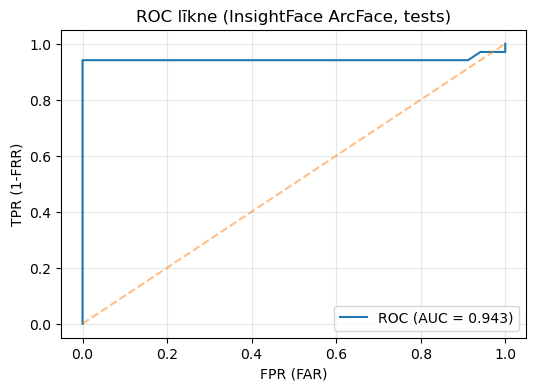

In [7]:
# --- 7) ROC + AUC (test) ---
genuine_t, impostor_t = [], []
for pname in persons:
    for ip in list_images(BASE / pname / "test"):
        q = encode_one(ip)
        if q is None: continue
        qn = l2n(q)
        sims = [cosine_similarity(qn, g) for g in gal_vecs]
        mask = (gal_names == pname)
        if mask.any():   genuine_t.append(np.max(np.array(sims)[mask]))
        if (~mask).any(): impostor_t.append(np.max(np.array(sims)[~mask]))

def roc_auc_from_scores(genuine, impostor, n=400):
    if len(genuine)==0 or len(impostor)==0: return [0],[0],np.nan
    taus = np.linspace(1, -1, n)   # <-- mainīts virziens!
    FPR, TPR = [], []
    for t in taus:
        FAR = (impostor >= t).mean()
        TPRv = (genuine >= t).mean()
        FPR.append(FAR); TPR.append(TPRv)
    auc = np.trapz(TPR, FPR)
    return FPR, TPR, auc

tau_eer_test, eer_test = eer_from_scores(np.array(genuine_t), np.array(impostor_t))
FPR, TPR, auc_test = roc_auc_from_scores(np.array(genuine_t), np.array(impostor_t))

print(f"\nEER(test) ≈ {100*eer_test:.2f}%  |  AUC(ROC, test) = {auc_test:.4f}  |  τ_EER(test) = {tau_eer_test:.4f}")
print(f"EER(val)  ≈ {100*eer_val:.2f}%  |  τ_EER(val)  = {tau_eer:.4f}")

plt.figure(figsize=(6,4))
plt.plot(FPR, TPR, label=f"ROC (AUC = {auc_test:.3f})")
plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel("FPR (FAR)"); plt.ylabel("TPR (1-FRR)")
plt.title("ROC līkne (InsightFace ArcFace, tests)")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


In [8]:
# --- 8) Kļūdaino piemēru izvadīšana ---
print("\n--- Personas ar kļūdām ---")
errors = []
for pname, fname, pred, score, ms, fps, ram, cpu in rows:
    if pred != pname:  # prognoze nesakrīt ar patieso personu
        errors.append((pname, fname, pred, score, ms, fps, ram, cpu))

if not errors:
    print("Kļūdainu atpazīšanu nav.")
else:
    for (pname, fname, pred, score, ms, fps, ram, cpu) in errors:
        print(f"{pname}: fails={fname} | prognoze={pred} | dist={score:.4f} | ms={ms:.2f} | FPS={fps:.1f}")



--- Personas ar kļūdām ---
person10: fails=person_10_018.jpg | prognoze=Unknown | dist=0.0770 | ms=0.23 | FPS=4393.7
person10: fails=person_10_020.jpg | prognoze=Unknown | dist=0.0820 | ms=0.23 | FPS=4264.4
